In [148]:
from google.colab import drive
drive.mount('/content/drive')
paths = '/content/drive/MyDrive/BRICS_MAIN/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [149]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
train_data = pd.read_csv(paths+'TRAIN.csv')
test_data = pd.read_csv(paths+'PUBLIC_TEST.csv',nrows=8760)

In [150]:
train_df  = train_data.drop(['Original Res Forecast before Lockdown','Hydro Water SCO','CSP Installed Capacity'],axis=1)
test_df   = test_data.drop(['Original Res Forecast before Lockdown','Hydro Water SCO','CSP Installed Capacity'],axis=1)

In [151]:
#DEAL WITH OUTLIERS
from ipywidgets.widgets.interaction import Real

for col in ['Other RE','Ingula Gen Unit Hours']:
    for data in [train_df,test_df]:
      q1 = data[col].quantile(.25)
      # Select the third quantile
      q3 = data[col].quantile(.75)
      # Create a mask inbeetween q1 & q3
      mask = data[col].between(q1, q3, inclusive=True)
      # Filtering the initial dataframe with a mask
      no_outlier = data.loc[mask, col]
      data[col] = no_outlier

train_df.dropna(subset = ['Unnamed: 42','Other RE','Ingula Gen Unit Hours'], inplace=True)
test_df.dropna(subset = ['Unnamed: 42','Other RE','Ingula Gen Unit Hours'], inplace=True)

<ipython-input-151-2908abdcc16e>:10: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  mask = data[col].between(q1, q3, inclusive=True)
<ipython-input-151-2908abdcc16e>:10: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  mask = data[col].between(q1, q3, inclusive=True)
<ipython-input-151-2908abdcc16e>:10: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  mask = data[col].between(q1, q3, inclusive=True)
<ipython-input-151-2908abdcc16e>:10: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  mask = data[col].between(q1, q3, inclusive=True)


<ipython-input-152-0ee777b4f638>:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = train_df.corr()


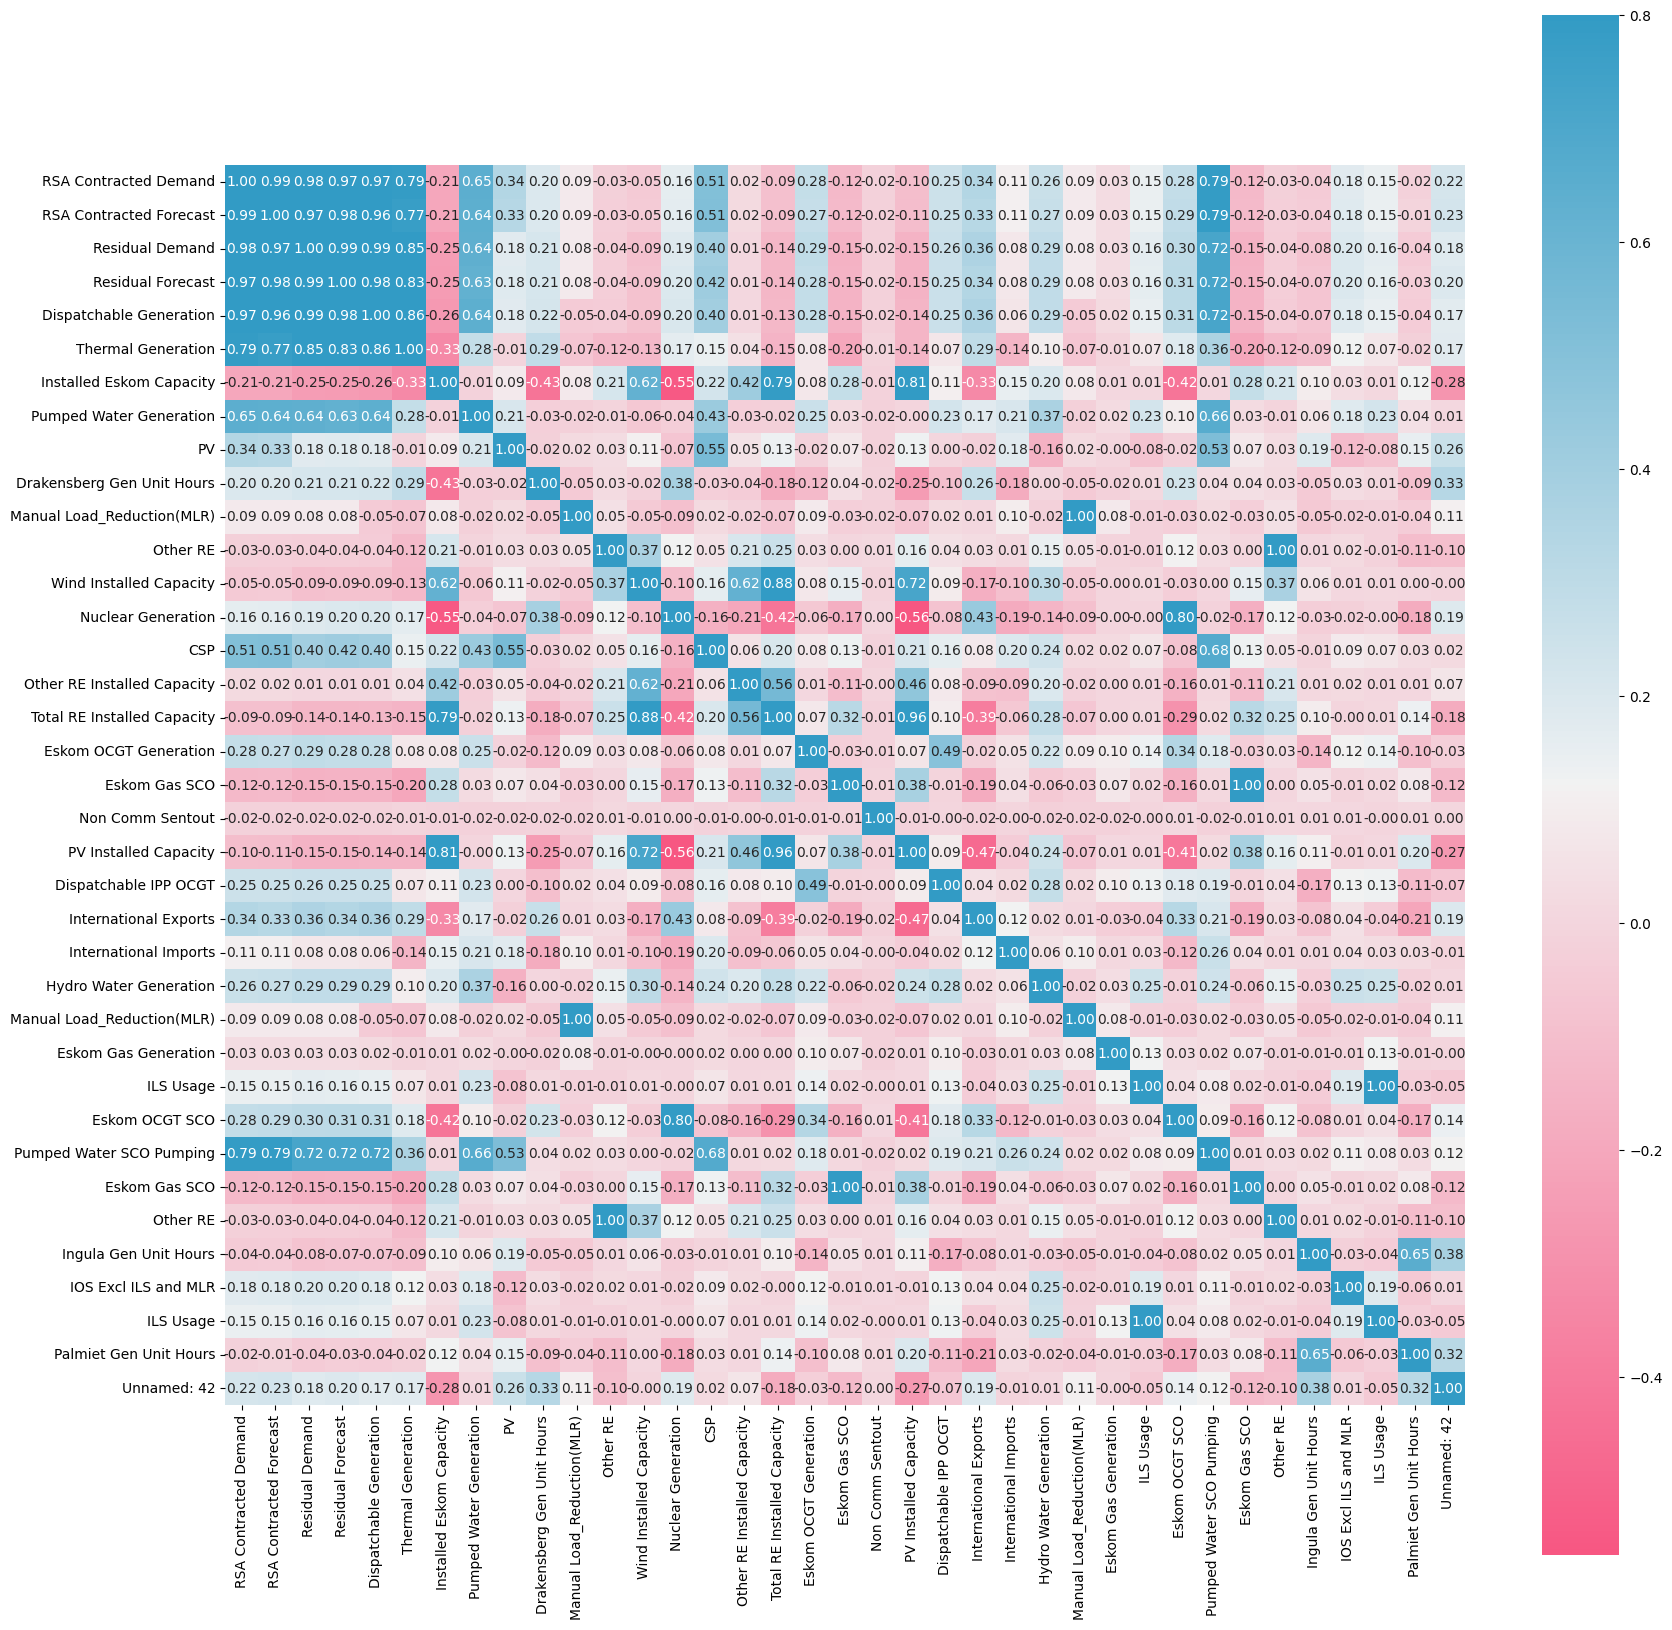

In [152]:
numerical_columns = ['RSA Contracted Demand','RSA Contracted Forecast','Residual Demand','Residual Forecast',
                    'Dispatchable Generation','Thermal Generation','Installed Eskom Capacity','Pumped Water Generation',
                    'PV','Drakensberg Gen Unit Hours','Manual Load_Reduction(MLR)','Other RE',
                    'Wind Installed Capacity','Nuclear Generation','CSP','Other RE Installed Capacity',
                    'Total RE Installed Capacity','Eskom OCGT Generation','Eskom Gas SCO','Non Comm Sentout','PV Installed Capacity',
                    'Dispatchable IPP OCGT','International Exports','International Imports','Hydro Water Generation','Manual Load_Reduction(MLR)',
                    'Eskom Gas Generation','ILS Usage','Eskom OCGT SCO','Pumped Water SCO Pumping','Eskom Gas SCO',
                    'Other RE','Ingula Gen Unit Hours','IOS Excl ILS and MLR','ILS Usage','Palmiet Gen Unit Hours','Unnamed: 42']

cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)

corrmat = train_df.corr()
k = 30 # Number of variables for heatmap
cols = corrmat.nlargest(k, 'Total OCLF')['Total OCLF'].index
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(train_df[numerical_columns].corr(), vmax=.8, square=True, cmap=cmap, annot=True, fmt=".2f");

# Assuming you have already calculated the correlation matrix `corrmat`

# Create a DataFrame to store the pairs of columns and their correlations
negative_correlations = []

# Iterate through the correlation matrix and identify negative correlations
for column1 in corrmat.columns:
    for column2 in corrmat.index:
        correlation = corrmat.loc[column2, column1]
        if column1 != column2 and correlation < 0:
            if column2 == 'Total OCLF':
              negative_correlations.append((column1, column2, correlation))

# Create a DataFrame from the list of negative correlations
negative_corr_df = pd.DataFrame(negative_correlations, columns=['Column1', 'Column2', 'Correlation'])

# Display the DataFrame of negative correlations
consider_drop_Total_OCLF = list(negative_corr_df['Column1'].values)

<ipython-input-153-dd7595ea1119>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = train_df.corr()


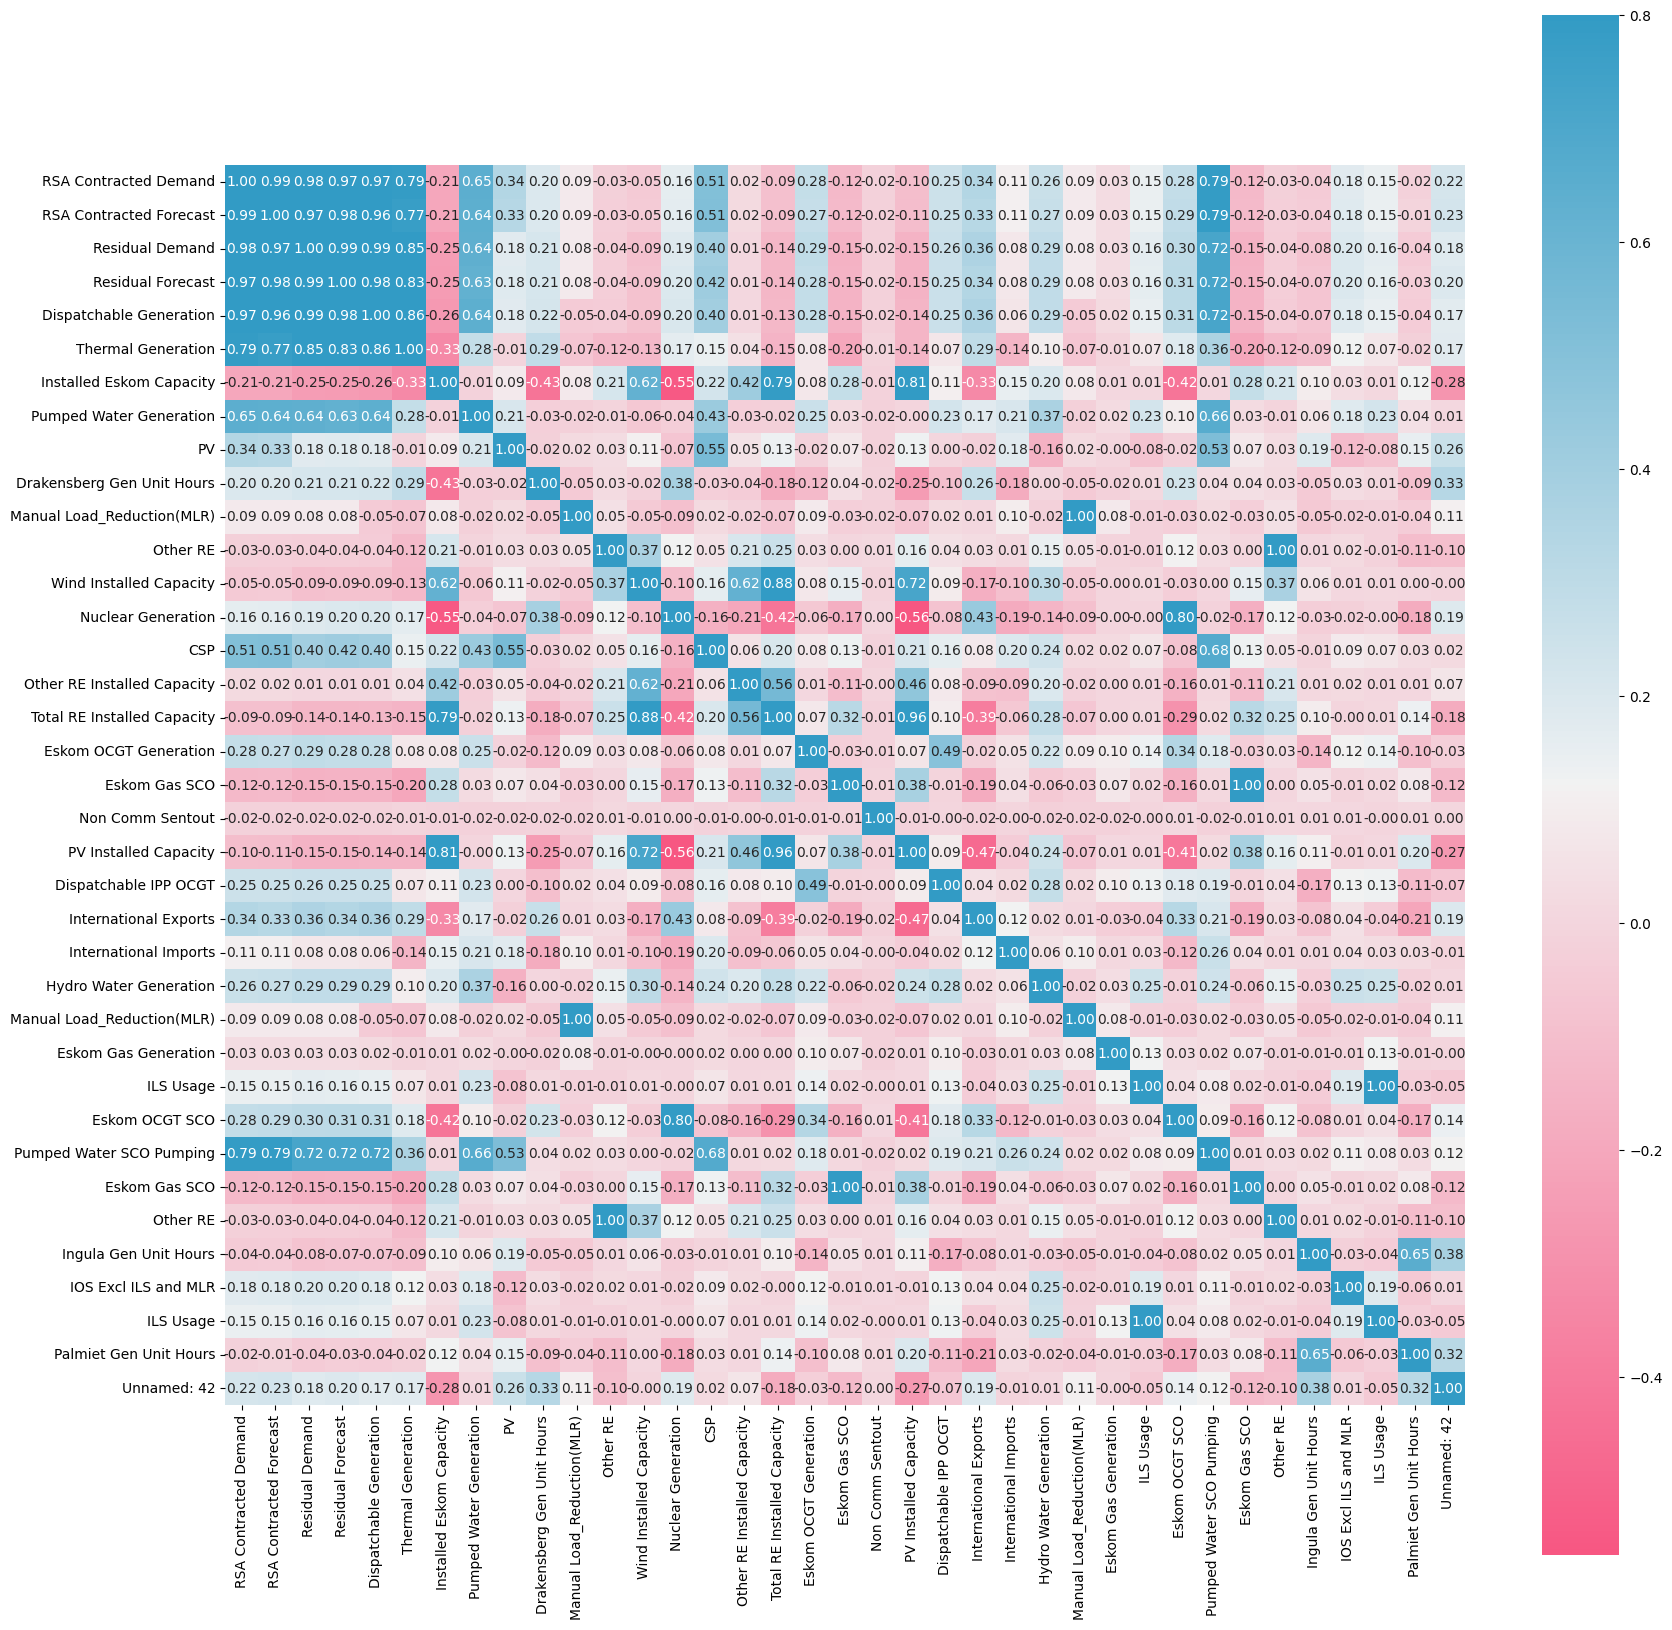

In [153]:
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)

corrmat = train_df.corr()
k = 30 # Number of variables for heatmap
cols = corrmat.nlargest(k, 'Total UCLF')['Total UCLF'].index
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(train_df[numerical_columns].corr(), vmax=.8, square=True, cmap=cmap, annot=True, fmt=".2f");

import pandas as pd

# Assuming you have already calculated the correlation matrix `corrmat`

# Create a DataFrame to store the pairs of columns and their correlations
negative_correlations = []

# Iterate through the correlation matrix and identify negative correlations
for column1 in corrmat.columns:
    for column2 in corrmat.index:
        correlation = corrmat.loc[column2, column1]
        if column1 != column2 and correlation < 0:
            if column2 == 'Total UCLF':
              negative_correlations.append((column1, column2, correlation))

# Create a DataFrame from the list of negative correlations
negative_corr_df = pd.DataFrame(negative_correlations, columns=['Column1', 'Column2', 'Correlation'])

# Display the DataFrame of negative correlations
consider_drop_Total_UCLF = list(negative_corr_df['Column1'].values)

In [154]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()

train_df['x_data']= pd.to_datetime(train_df['Date Time Hour Beginning'])
train_df['x_month'] = train_df['x_data'].dt.month.astype(int)
train_df['year'] = train_df['x_data'].dt.year.astype(int)
train_df['x_day'] = train_df['x_data'].dt.day.astype(int)
train_df['hour'] = train_df['x_data'].dt.hour.astype(int)
train_df['min'] = train_df['x_data'].dt.minute.astype(int)

train_df['s_quarter']=train_df['x_data'].dt.quarter
train_df['s_weekday'] = (train_df['x_day'] // 5 == 1).astype(float)
train_df['dayofweek'] = train_df['x_data'].dt.dayofweek
train_df['DayOfYear'] = train_df['x_data'].dt.dayofyear
train_df['ismonthstart'] = train_df['x_data'].dt.is_month_start
train_df['ismonthend'] = train_df['x_data'].dt.is_month_end


test_df['x_data']= pd.to_datetime(test_df['Date Time Hour Beginning'])
test_df['x_month'] = test_df['x_data'].dt.month.astype(int)
test_df['year'] = test_df['x_data'].dt.year.astype(int)
test_df['x_day'] = test_df['x_data'].dt.day.astype(int)
test_df['hour'] = test_df['x_data'].dt.hour.astype(int)
test_df['min'] = test_df['x_data'].dt.minute.astype(int)
test_df['s_quarter']=test_df['x_data'].dt.quarter
test_df['s_weekday'] = (test_df['x_day'] // 5 == 1).astype(float)
test_df['DayOfYear'] = test_df['x_data'].dt.dayofyear
test_df['ismonthstart'] = test_df['x_data'].dt.is_month_start
test_df['ismonthend'] = test_df['x_data'].dt.is_month_end



experiment_columns = ['RSA Contracted Demand','RSA Contracted Forecast','Residual Demand','Residual Forecast',
                'Dispatchable Generation','Thermal Generation','Installed Eskom Capacity',
                'Wind Installed Capacity','CSP','Other RE Installed Capacity','Non Comm Sentout','Dispatchable IPP OCGT','Hydro Water Generation',
                'Manual Load_Reduction(MLR)','Eskom Gas Generation','ILS Usage','Pumped Water SCO Pumping','Other RE','Ingula Gen Unit Hours','IOS Excl ILS and MLR',
                'ILS Usage','Unnamed: 42']

so_far_columns = ['s_quarter','s_weekday','DayOfYear','ismonthstart', 'ismonthend', 'min','hour','x_month','x_day','year','RSA Contracted Demand','RSA Contracted Forecast','Residual Demand','Residual Forecast',
                    'Dispatchable Generation','Thermal Generation','Installed Eskom Capacity','Pumped Water Generation',
                    'PV','Drakensberg Gen Unit Hours','Manual Load_Reduction(MLR)','Other RE',
                    'Wind Installed Capacity','Nuclear Generation','CSP','Other RE Installed Capacity',
                    'Total RE Installed Capacity','Eskom OCGT Generation','Eskom Gas SCO','Non Comm Sentout','PV Installed Capacity',
                    'Dispatchable IPP OCGT','International Exports','International Imports','Hydro Water Generation','Manual Load_Reduction(MLR)',
                    'Eskom Gas Generation','ILS Usage','Eskom OCGT SCO','Pumped Water SCO Pumping','Eskom Gas SCO',
                    'Other RE','Ingula Gen Unit Hours','IOS Excl ILS and MLR','ILS Usage','Palmiet Gen Unit Hours','Unnamed: 42']


print(len(so_far_columns))

target_cols = ['Total UCLF','Total OCLF']
lr_models = {}

y_train = train_df[target_cols]
y_val = test_df[target_cols]

X_train = train_df.drop(['Total UCLF','Total OCLF','Total UCLF+OCLF','x_data'],axis=1)
X_test = test_df.drop(['Total UCLF','Total OCLF','Total UCLF+OCLF','x_data'],axis=1)

#X_train_oclf = X_train[list(set(so_far_columns) - set(consider_drop_Total_OCLF))]
#X_test_oclf = X_test[list(set(so_far_columns) - set(consider_drop_Total_OCLF))]

X_train_uclf = X_train[so_far_columns]
X_test_uclf = X_test[so_far_columns]

print(len(X_train_uclf))
print(len(y_train))

#X_train_uclf = X_train[list(set(so_far_columns) - set(consider_drop_Total_UCLF))]
#X_test_uclf = X_test[list(set(so_far_columns) - set(consider_drop_Total_UCLF))]

X_train_oclf = X_train[so_far_columns]
X_test_oclf = X_test[so_far_columns]

y_pred = []

for target_col in target_cols:
  lr_model = LinearRegression()
  if target_col == 'Total OCLF':
    X_train_scaled = scaler1.fit_transform(X_train_oclf)
  elif target_col == 'Total UCLF':
     X_train_scaled = scaler2.fit_transform(X_train_uclf)
  lr_model.fit(X_train_scaled, y_train[target_col])
  lr_models[target_col] = lr_model

print(lr_models)
for target_col in target_cols:
   if target_col == 'Total OCLF':
    X_val_scaled = scaler1.transform(X_test_oclf)
   elif target_col == 'Total UCLF':
    X_val_scaled = scaler2.transform(X_test_uclf)

   lr_model = lr_models[target_col]
   y_pred_col = lr_model.predict(X_val_scaled)
   y_pred.append(y_pred_col)

df1 = pd.DataFrame({'y_pred': y_pred[0], 'y_val': y_val[target_cols[0]].values})
df2 = pd.DataFrame({'y_pred': y_pred[1], 'y_val': y_val[target_cols[1]].values})

rmse_uclf = np.sqrt(mean_squared_error(df1['y_pred'], df1['y_val']))
rmse_oclf = np.sqrt(mean_squared_error(df2['y_pred'], df2['y_val']))


print(f'RMSE_UCLF: {rmse_uclf}')
print(f'RMSE_OCLF: {rmse_oclf}')


47
5071
5071
{'Total UCLF': LinearRegression(), 'Total OCLF': LinearRegression()}
RMSE_UCLF: 6713.45820699787
RMSE_OCLF: 10672.172766267113


In [155]:
import pandas as pd
from scipy import stats
from tqdm import tqdm

print(X_train_uclf.columns)
#Feat ENG FOR DEEP LEARNING

X_train_uclf ['Rsa_'] = X_train_uclf['RSA Contracted Demand'] - X_train_uclf['RSA Contracted Forecast']
X_test_uclf ['Rsa_'] = X_test_uclf['RSA Contracted Demand'] - X_test_uclf['RSA Contracted Forecast']
X_train_oclf ['Rsa_'] = X_train_oclf['RSA Contracted Demand'] - X_train_oclf['RSA Contracted Forecast']
X_test_oclf ['Rsa_'] = X_test_oclf['RSA Contracted Demand'] - X_test_oclf['RSA Contracted Forecast']


X_train_uclf ['Rsa_ration'] = X_train_uclf['RSA Contracted Demand'] / X_train_uclf['RSA Contracted Forecast']
X_test_uclf ['Rsa_ration'] = X_test_uclf['RSA Contracted Demand'] /X_test_uclf['RSA Contracted Forecast']
X_train_oclf ['Rsa_ration'] = X_train_oclf['RSA Contracted Demand'] / X_train_oclf['RSA Contracted Forecast']
X_test_oclf ['Rsa_ration'] = X_test_oclf['RSA Contracted Demand'] /X_test_oclf['RSA Contracted Forecast']


X_train_uclf ['import_'] = X_train_uclf['International Imports'] - X_train_uclf['International Exports']
X_test_uclf ['import_'] = X_test_uclf['International Imports'] - X_test_uclf['International Exports']
X_train_oclf ['import_'] = X_train_oclf['International Imports'] - X_train_oclf['International Exports']
X_test_oclf ['import_'] = X_test_oclf['International Imports'] - X_test_oclf['International Exports']


X_train_uclf ['import_ration'] = X_train_uclf['International Imports'] / X_train_uclf['International Exports']
X_test_uclf ['import_ration'] = X_test_uclf['International Imports'] / X_test_uclf['International Exports']
X_train_oclf ['import_ration'] = X_train_oclf['International Imports'] / X_train_oclf['International Exports']
X_test_oclf ['import_ration'] = X_test_oclf['International Imports'] / X_test_oclf['International Exports']


X_train_uclf ['residual_'] = X_train_uclf['Residual Demand'] - X_train_uclf['Residual Demand']
X_test_uclf ['residual_'] = X_test_uclf['Residual Demand'] - X_test_uclf['Residual Demand']

X_train_oclf ['residual_'] = X_train_oclf['Residual Demand'] - X_train_oclf['Residual Demand']
X_test_oclf ['residual_'] = X_test_oclf['Residual Demand'] - X_test_oclf['Residual Demand']

X_train_uclf ['residual_ration'] = X_train_uclf['Residual Demand'] / X_train_uclf['Residual Demand']
X_test_uclf ['residual_ration'] = X_test_uclf['Residual Demand'] / X_test_uclf['Residual Demand']

X_train_oclf ['residual_ration'] = X_train_oclf['Residual Demand'] / X_train_oclf['Residual Demand']
X_test_oclf ['residual_ration'] = X_test_oclf['Residual Demand'] / X_test_oclf['Residual Demand']



Index(['s_quarter', 's_weekday', 'DayOfYear', 'ismonthstart', 'ismonthend',
       'min', 'hour', 'x_month', 'x_day', 'year', 'RSA Contracted Demand',
       'RSA Contracted Forecast', 'Residual Demand', 'Residual Forecast',
       'Dispatchable Generation', 'Thermal Generation',
       'Installed Eskom Capacity', 'Pumped Water Generation', 'PV',
       'Drakensberg Gen Unit Hours', 'Manual Load_Reduction(MLR)', 'Other RE',
       'Wind Installed Capacity', 'Nuclear Generation', 'CSP',
       'Other RE Installed Capacity', 'Total RE Installed Capacity',
       'Eskom OCGT Generation', 'Eskom Gas SCO', 'Non Comm Sentout',
       'PV Installed Capacity', 'Dispatchable IPP OCGT',
       'International Exports', 'International Imports',
       'Hydro Water Generation', 'Manual Load_Reduction(MLR)',
       'Eskom Gas Generation', 'ILS Usage', 'Eskom OCGT SCO',
       'Pumped Water SCO Pumping', 'Eskom Gas SCO', 'Other RE',
       'Ingula Gen Unit Hours', 'IOS Excl ILS and MLR', 'ILS Usage',

<ipython-input-155-65e1a0f39e65>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_uclf ['Rsa_'] = X_test_uclf['RSA Contracted Demand'] - X_test_uclf['RSA Contracted Forecast']
<ipython-input-155-65e1a0f39e65>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_oclf ['Rsa_'] = X_test_oclf['RSA Contracted Demand'] - X_test_oclf['RSA Contracted Forecast']
<ipython-input-155-65e1a0f39e65>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [156]:
import pandas as pd
pd.set_option('display.max_rows', None)
import numpy  as np
from tensorflow import keras
import matplotlib.pyplot as plt
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

def data_label(label_type,data_in):
  train_X, valid_X, train_y, valid_y = train_test_split(data_in,train_df[label_type],
                                                  test_size=0.2,
                                                  random_state=42,
                                                  shuffle=True)
  return  train_X, valid_X, train_y, valid_y

def transformedData(train_data,valid_data,test_data):
  scaler  = MinMaxScaler()
  train_data = scaler.fit_transform(train_data)
  valid_data   = scaler.transform(valid_data)
  test_data =scaler.transform(test_data)
  return train_data,valid_data,test_data


train_uclf, valid_uclf, train_y_uclf, y_valid_uclf = data_label('Total UCLF',X_train_uclf)
X_uclf,X_val_uclf,test_uclf =  transformedData(train_uclf, valid_uclf,X_test_uclf)


train_oclf, valid_oclf, train_y_oclf, y_valid_oclf = data_label('Total OCLF',X_train_oclf)
X_oclf,X_val_oclf,test_oclf =  transformedData(train_oclf, valid_oclf,X_test_oclf)


def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

# Create a Sequential model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2

# Define a Sequential model with regularization

# Create a Sequential model
model1 = keras.Sequential([
    # First hidden layer with 64 units and ReLU activation function
    Dense(64, activation='relu', input_shape=(train_uclf.shape[-1],)),

    Dropout(0.3),

    # Second hidden layer with 64 units and ReLU activation function
    Dense(64, activation='relu'),

    # Adding more hidden layers with 128 units and ReLU activation
    Dense(128, activation='relu'),
    Dropout(0.3),  # Dropout layer
    Dense(128, activation='relu'),

    # Output layer with 1 unit for regression, no activation function
    Dense(1)
])


# Compile the model with an appropriate loss function (e.g., mean squared error for regression)

initial_weights = model1.get_weights()
learning_rate = 0.001

model1.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
              loss = root_mean_squared_error,
              metrics=['mean_absolute_error']
             )

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta = 0.0002, # minimium amount of change to count as an improvement
    patience  = 20,     # how many epochs to wait before stopping
    restore_best_weights=True,
)

history = model1.fit(X_uclf, train_y_uclf,
          epochs=500,
          batch_size=500,
          validation_data=(X_val_uclf, y_valid_uclf),
          verbose=0,
          callbacks=[early_stopping]
                    )
uclf_pred = model1.predict(test_uclf)

def flatten(l):
    return [item for sublist in l for item in sublist]
ulf_pred = flatten(uclf_pred)
df3 = pd.DataFrame({'y_pred': ulf_pred, 'y_val': y_val[target_cols[0]].values})
deep_rmse_uclf = np.sqrt(mean_squared_error(df3['y_pred'], df3['y_val']))
print(f'RMSE_UCLF: {deep_rmse_uclf}')



# Create a Sequential model
model2 = keras.Sequential([
    # First hidden layer with 64 units and ReLU activation function
    Dense(64, activation='relu', input_shape=(train_oclf.shape[-1],)),

    Dropout(0.3),

    # Second hidden layer with 64 units and ReLU activation function
    Dense(64, activation='relu'),

    # Adding more hidden layers with 128 units and ReLU activation
    Dense(128, activation='relu'),
    Dropout(0.3),  # Dropout layer
    Dense(128, activation='relu'),

    # Output layer with 1 unit for regression, no activation function
    Dense(1)
])


# Compile the model with an appropriate loss function (e.g., mean squared error for regression)

initial_weights = model2.get_weights()
learning_rate = 0.001

model2.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
              loss = root_mean_squared_error,
              metrics=['mean_absolute_error']
             )


history2 = model2.fit(X_oclf, train_y_oclf,
          epochs=500,
          batch_size=500,
          validation_data=(X_val_oclf, y_valid_oclf),
          verbose=0,
          callbacks=[early_stopping]
                    )
oclf_pred = model2.predict(test_oclf)
olf_pred = flatten(oclf_pred)
df4 = pd.DataFrame({'y_pred': olf_pred, 'y_val': y_val[target_cols[1]].values})
deep_rmse_oclf = np.sqrt(mean_squared_error(df4['y_pred'], df4['y_val']))
print(f'RMSE_OCLF: {deep_rmse_oclf}')

print(df3.head(10))
print(df4.head(10))



71/71 [==============================] - 0s 2ms/step
RMSE_UCLF: 3893.0878315987247
71/71 [==============================] - 0s 2ms/step
RMSE_OCLF: 541.8311229759942
         y_pred      y_val
0  10117.800781  11715.034
1   9889.867188  11691.594
2   9717.562500  11670.068
3   9028.994141  11654.832
4   9114.013672  11697.397
5   8873.717773  11584.775
6   8811.838867  11454.883
7   9143.804688  11613.440
8   9162.310547  11650.206
9   8863.771484  12018.074
        y_pred     y_val
0  1295.994141  1567.774
1  1273.511108  1567.774
2  1250.859253  1567.774
3  1322.266479  1562.934
4  1474.453003  1576.283
5  1522.476685  1575.910
6  1604.834473  1558.910
7  1417.701782  1398.966
8  1374.747070  1280.031
9  1452.369751  1340.664


In [157]:
forcast_df  = train_data.drop(['Original Res Forecast before Lockdown','Hydro Water SCO','CSP Installed Capacity','Unnamed: 42'],axis=1)
forcast_df['Datetime'] = pd.to_datetime(forcast_df['Date Time Hour Beginning'])
forcast_df = forcast_df.set_index('Datetime')
forcast_df  = forcast_df.drop(['Date Time Hour Beginning'],axis=1)

test_df   = test_data.drop(['Original Res Forecast before Lockdown','Hydro Water SCO','CSP Installed Capacity','Unnamed: 42'],axis=1)
test_df['Datetime'] = pd.to_datetime(test_df['Date Time Hour Beginning'])
test_df  = test_df.drop(['Date Time Hour Beginning'],axis=1)
test_df = test_df.set_index('Datetime')


def fill_missing(values,df):
    one_day = 60*24*36
    for row in range(df.shape[0]):
        for col in range(df.shape[1]):
            if pd.isna(values[row][col]):
                values[row,col] = values[row-one_day,col]

forcast_df = forcast_df.astype('float32')
test_df = test_df.astype('float32')

fill_missing(forcast_df.values,forcast_df)
fill_missing(test_df.values,test_df)
forcast_df.isnull().sum()

train_df = forcast_df.resample('D').sum()

train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df

for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s


In [158]:
def split_series(series, n_past, n_future):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations
  #
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)


n_past = 10
n_future = 5
n_features = 38

X_train, y_train = split_series(train.values,n_past, n_future)

X_train = np.array([np.array(val) for val in X_train])
print(X_train.shape)
#X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
#y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = np.array([np.array(val) for val in X_test])
print(X_train.shape)
#X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
#y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

(766, 10, 38)
(766, 10, 38)


In [159]:
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

#
model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

#
model_e1d1.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_20 (InputLayer)       [(None, 10, 38)]             0         []                            
                                                                                                  
 lstm_55 (LSTM)              [(None, 100),                55600     ['input_20[0][0]']            
                              (None, 100),                                                        
                              (None, 100)]                                                        
                                                                                                  
 repeat_vector_18 (RepeatVe  (None, 5, 100)               0         ['lstm_55[0][0]']             
 ctor)                                                                                     

In [160]:
# E2D2
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
#
model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model_e2d2.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_21 (InputLayer)       [(None, 10, 38)]             0         []                            
                                                                                                  
 lstm_57 (LSTM)              [(None, 10, 100),            55600     ['input_21[0][0]']            
                              (None, 100),                                                        
                              (None, 100)]                                                        
                                                                                                  
 lstm_58 (LSTM)              [(None, 100),                80400     ['lstm_57[0][0]']             
                              (None, 100),                                                 

In [161]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e1d1=model_e1d1.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=1,callbacks=[reduce_lr])
model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2=model_e2d2.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=1,callbacks=[reduce_lr])

Epoch 1/25
24/24 [==============================] - 9s 158ms/step - loss: 0.0938 - val_loss: 2.8226 - lr: 0.0010
Epoch 2/25
24/24 [==============================] - 2s 96ms/step - loss: 0.0446 - val_loss: 2.7358 - lr: 9.0000e-04
Epoch 3/25
24/24 [==============================] - 2s 96ms/step - loss: 0.0368 - val_loss: 2.7139 - lr: 8.1000e-04
Epoch 4/25
24/24 [==============================] - 2s 94ms/step - loss: 0.0339 - val_loss: 2.7049 - lr: 7.2900e-04
Epoch 5/25
24/24 [==============================] - 3s 130ms/step - loss: 0.0324 - val_loss: 2.6943 - lr: 6.5610e-04
Epoch 6/25
24/24 [==============================] - 3s 121ms/step - loss: 0.0314 - val_loss: 2.6916 - lr: 5.9049e-04
Epoch 7/25
24/24 [==============================] - 2s 93ms/step - loss: 0.0306 - val_loss: 2.6875 - lr: 5.3144e-04
Epoch 8/25
24/24 [==============================] - 2s 95ms/step - loss: 0.0301 - val_loss: 2.6842 - lr: 4.7830e-04
Epoch 9/25
24/24 [==============================] - 2s 92ms/step - loss: 

In [162]:
pred_e1d1=model_e1d1.predict(X_test)
pred_e2d2=model_e2d2.predict(X_test)

274/274 [==============================] - 7s 14ms/step


In [163]:
for index,i in enumerate(train_df.columns):
    scaler = scalers['scaler_'+i]
    pred_e1d1[:,:,index]=scaler.inverse_transform(pred_e1d1[:,:,index])
    pred_e1d1[:,:,index]=scaler.inverse_transform(pred_e1d1[:,:,index])
    pred_e2d2[:,:,index]=scaler.inverse_transform(pred_e2d2[:,:,index])
    pred_e2d2[:,:,index]=scaler.inverse_transform(pred_e2d2[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])

In [164]:
from sklearn.metrics import mean_absolute_error
for index,i in enumerate(train_df.columns):
  print(i)
  for j in range(1,6):
    print("Hour ",j,":")
    print("MAE-E1D1 : ",mean_absolute_error(y_test[:,j-1,index],pred_e1d1[:,j-1,index]),end=", ")
    print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred_e2d2[:,j-1,index]))
  print()
  print()

Residual Forecast
Day  1 :
MAE-E1D1 :  63719473000.0, MAE-E2D2 :  68895280000.0
Day  2 :
MAE-E1D1 :  64784540000.0, MAE-E2D2 :  69504100000.0
Day  3 :
MAE-E1D1 :  66163814000.0, MAE-E2D2 :  70085930000.0
Day  4 :
MAE-E1D1 :  67644110000.0, MAE-E2D2 :  70581350000.0
Day  5 :
MAE-E1D1 :  68980690000.0, MAE-E2D2 :  70991815000.0


RSA Contracted Forecast
Day  1 :
MAE-E1D1 :  59296494000.0, MAE-E2D2 :  71560266000.0
Day  2 :
MAE-E1D1 :  59530150000.0, MAE-E2D2 :  71249250000.0
Day  3 :
MAE-E1D1 :  59821527000.0, MAE-E2D2 :  71174200000.0
Day  4 :
MAE-E1D1 :  60483375000.0, MAE-E2D2 :  71249880000.0
Day  5 :
MAE-E1D1 :  61372000000.0, MAE-E2D2 :  71463870000.0


Dispatchable Generation
Day  1 :
MAE-E1D1 :  66828014000.0, MAE-E2D2 :  69961500000.0
Day  2 :
MAE-E1D1 :  66054373000.0, MAE-E2D2 :  70246105000.0
Day  3 :
MAE-E1D1 :  66253644000.0, MAE-E2D2 :  70433360000.0
Day  4 :
MAE-E1D1 :  67036123000.0, MAE-E2D2 :  70527020000.0
Day  5 :
MAE-E1D1 :  68152330000.0, MAE-E2D2 :  70622530000.0
